In [2]:
# Standard imports
import sys
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%matplotlib inline
SEED=1

# Plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

# Cell timing
# https://github.com/cpcloud/ipython-autotime
%load_ext autotime

In [31]:
# Load data from previous
df = pd.read_csv('output/data-opiniosis.txt', sep='\t')
vectors = np.load('output/vectors-opiniosis.npy')

time: 46.1 ms


In [32]:
# This dataset has a groundtruth topic, so spend some time to annotate the dataframe with these topics
# Can be used later to verify different techniques
# Make a more higher level topic ground-truth based on the filenames

# Main topics (from filename)
df['topic_general'] = df.topic.map(lambda x: x[12:].split('_')[0])
df.loc[df.topic_general=='room','topic_general'] = 'rooms'
df.loc[df.topic_general=='gas','topic_general'] = 'mileage'

# Map general topics to topic_id, and wrap the text for later display
d = dict([(y,x+1) for x,y in enumerate(sorted(set(df.topic_general)))])
df['topic_id'] = df.topic_general.map(d)

time: 24.2 ms


In [33]:
# Split out the three main themes
def topic_gadget(x):
    gadget_topics = ['accuracy',
            'battery-life',
            'buttons',
            'display',
            'eyesight-issues',
            'features',
            'fonts',
            'keyboard',
            'navigation',
            'price',
            'screen',
            'sound',
            'updates',
            'video']
    if x in gadget_topics:
        return gadget_topics.index(x)+1
    else:
        return 0

def topic_hotel(x):
    hotel_topics = ['bathroom','food','free','location','parking','price','rooms','service','staff']
    if x in hotel_topics:
        return hotel_topics.index(x)+1
    else:
        return 0

def topic_car(x):
    car_topics = ['comfort','mileage','interior','performance','quality','seats']
    if x in car_topics:
        return car_topics.index(x)+1
    else:
        return 0
    
df['topic_gadget'] = df.topic_general.map(topic_gadget)
df['topic_hotel'] = df.topic_general.map(topic_hotel)
df['topic_car'] = df.topic_general.map(topic_car)

df.to_csv('output/data-opiniosis-topics.txt', sep='\t', index=False)

time: 131 ms


In [34]:
# Filter to just the "hotel" cluster, to reduce the complexity
idx = (df.x < 0)
df_hotel = df.loc[idx]
vectors_hotel = vectors[idx,:]

time: 10.3 ms


In [15]:
# Use spaCy to clean all the text, from which we can then generate bigrams and run LDA
import spacy
import string

model_punctuation = set(string.punctuation)
nlp = spacy.load('en', disable=['ner'])

time: 1 s


In [16]:
def clean_token(token):
    """Clean out any non-alphanumeric chararacters"""
    if (
            token.is_punct or
            token.pos_ == 'PUNCT' or
            token.pos_ == 'SPACE' or
            token.pos_ == 'PRON' or
            token.pos_ == 'X' or
            len(token.lemma_) > 15 or
            '@' in token.lemma_
    ) or token.lemma_ in ('the', 'to', 'be', 'a', 'and'): # basic stop-word removal
        return ''
    else:
        # Remove any non-alphanumeric characers from the lemma
        tmp_token = ''.join(ch for ch in token.lemma_ if (
            ch not in model_punctuation and ch.isalnum()
        ))
        return tmp_token
        
def generate_tokens(text):
    parsed = nlp(text)
    tokens = [w for w in (clean_token(t) for t in parsed) if w != '']
    return tokens

time: 13.4 ms


In [36]:
df_hotel['tokens'] = df_hotel.text.map(lambda x: generate_tokens(x))

time: 20.8 s


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Bigrams

In [37]:
import nltk
from nltk.collocations import BigramCollocationFinder

tokens = df_hotel.tokens.tolist()
tokens_flat = [item for sublist in tokens for item in sublist]

bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens_flat)

time: 135 ms


In [38]:
bigrams, counts = [], []
for k,v in finder.ngram_fd.items():
    bigrams.append(k)
    counts.append(v)

idx = np.argsort(counts)[::-1]
top10bigrams = np.asarray(bigrams)[idx][0:10]
top10counts = np.asarray(counts)[idx][0:10]

for b,c in zip(top10bigrams, top10counts):
    print_str = '[' + ', '.join(b) + ']'
    print(print_str.ljust(20),c)
    
print()

[great, location]    221
[PRON, room]         174
[do, not]            166
[this, hotel]        132
[room, service]      131
[staff, very]        92
[location, great]    90
[room, clean]        85
[check, in]          83
[front, desk]        81

time: 36.3 ms


# LDA

In [39]:
import gensim
import pyLDAvis.gensim
import pyLDAvis

docs_clean = df_hotel.tokens.tolist()
dictionary = gensim.corpora.Dictionary(docs_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs_clean]

time: 554 ms


In [40]:
num_topics = 5
ldamodel = gensim.models.ldamodel.LdaModel(
    doc_term_matrix,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    minimum_probability=0
)
scored = ldamodel[doc_term_matrix]
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




time: 1min 3s


In [41]:
num_topics = 10
ldamodel = gensim.models.ldamodel.LdaModel(
    doc_term_matrix,
    num_topics=num_topics,
    id2word=dictionary,
    passes=50,
    minimum_probability=0
)
scored = ldamodel[doc_term_matrix]
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




time: 57.4 s


In [42]:
# Compare this with the actuals
def get_max_topic(t):
    s = np.array(t)
    max_topic = s[np.argmax(s, axis=0)[1]][0]
    return max_topic
    
lda_topics = [get_max_topic(s) for s in scored]
df_hotel['lda_topic_id'] = lda_topics

time: 1.02 s


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



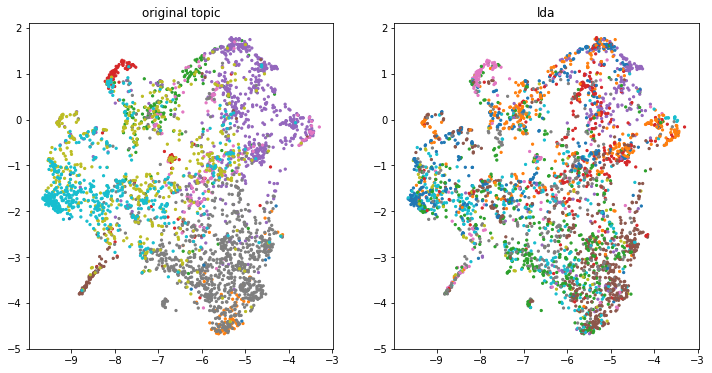

time: 602 ms


In [43]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.topic_hotel, cmap=plt.cm.tab10)
plt.title('original topic')

plt.subplot(122)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.lda_topic_id, cmap=plt.cm.tab10)
plt.title('lda')

plt.show()

# Wordcloud

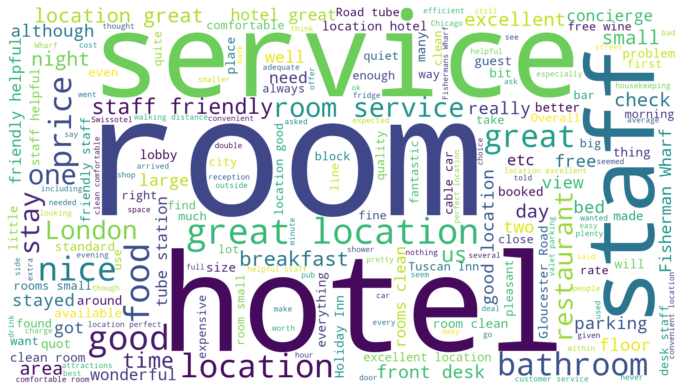

time: 3.64 s


In [44]:
# Wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1600, height=900).generate('. '.join(df_hotel.text.tolist()))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# K means

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=SEED).fit(vectors_hotel)
df_hotel['kmeans_topics'] = kmeans.labels_

time: 2.04 s


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



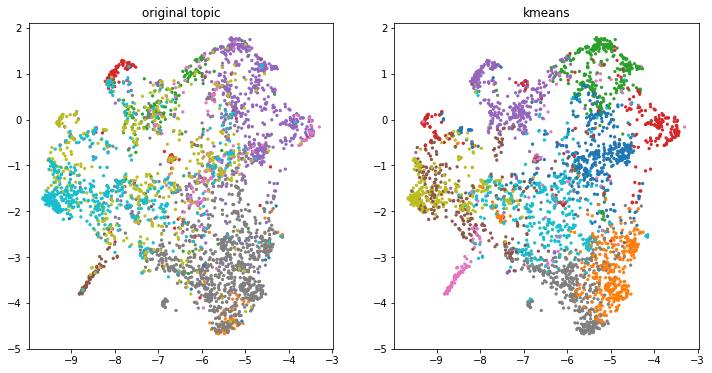

time: 573 ms


In [52]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.topic_hotel, cmap=plt.cm.tab10)
plt.title('original topic')

plt.subplot(122)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.kmeans_topics, cmap=plt.cm.tab10)
plt.title('kmeans')

plt.show()

# Gmm

In [53]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, covariance_type='full').fit(vectors_hotel)
df_hotel['gmm_topic'] = gmm.predict(vectors_hotel)

time: 2.78 s


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



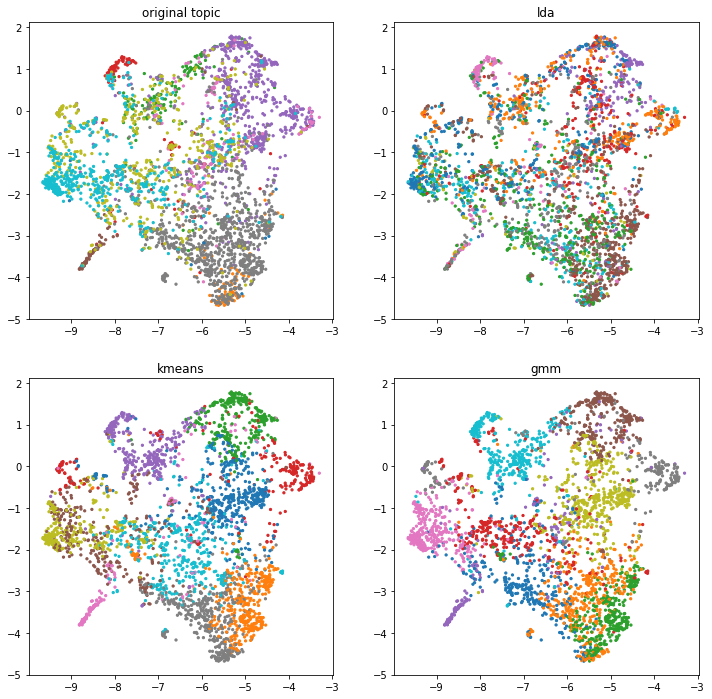

time: 1.33 s


In [54]:
df_hotel.topic_hotel.iloc[0] = 0

plt.figure(figsize=(12,12))

plt.subplot(221)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.topic_hotel, cmap=plt.cm.tab10)
plt.title('original topic')

plt.subplot(222)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.lda_topic_id, cmap=plt.cm.tab10)
plt.title('lda')

plt.subplot(223)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.kmeans_topics, cmap=plt.cm.tab10)
plt.title('kmeans')

plt.subplot(224)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=df_hotel.gmm_topic, cmap=plt.cm.tab10)
plt.title('gmm')

plt.show()

In [58]:
# Plotly version for manual topic discovery
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=df_hotel.x,
                y=df_hotel.y,
                text=df_hotel.topic_general.str.upper() + '--' + df_hotel.textwrap,
                mode='markers',
                marker=dict(
                        size=5,
                        colorscale=matplotlib_to_plotly(plt.cm.tab10, 255),
                        color=df_hotel.lda_topic_id,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 330 ms


## Difference between doing it on full space or 2D space

## Visualise gmm

https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [59]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, ec='k', **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

time: 88.5 ms


## Difference between Kmeans / GMM (viz on 2D vectors)

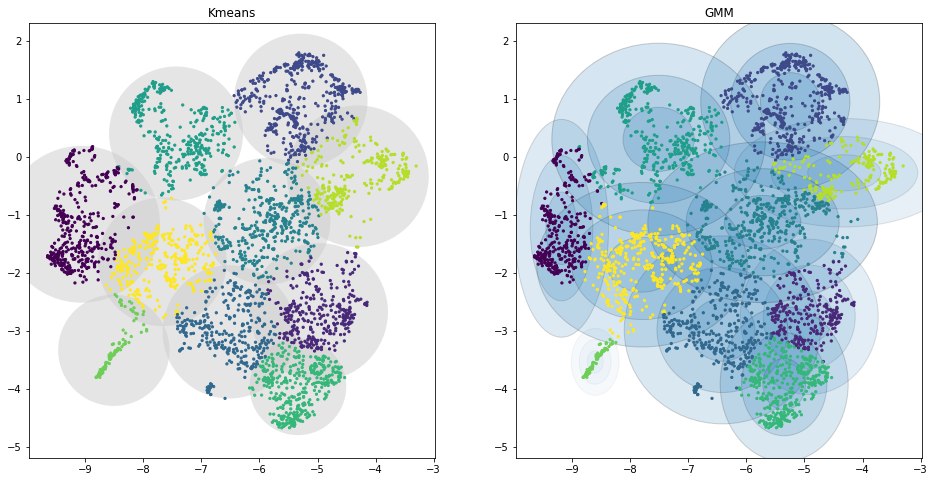

time: 1.21 s


In [60]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

# Get the 2D vectors
vectors_hotel_2d = np.array([df_hotel.x, df_hotel.y]).T

kmeans = KMeans(n_clusters=10, random_state=0).fit(vectors_hotel_2d)
gmm1 = GaussianMixture(n_components=10, random_state=0, covariance_type='diag').fit(vectors_hotel_2d)
gmm2 = GaussianMixture(n_components=10, random_state=0, covariance_type='full').fit(vectors_hotel_2d)

plt.figure(figsize=(16,8))

plt.subplot(121)
plot_kmeans(kmeans, vectors_hotel_2d)
plt.title("Kmeans")

plt.subplot(122)
plot_gmm(gmm1, vectors_hotel_2d)
plt.title("GMM")

plt.show()


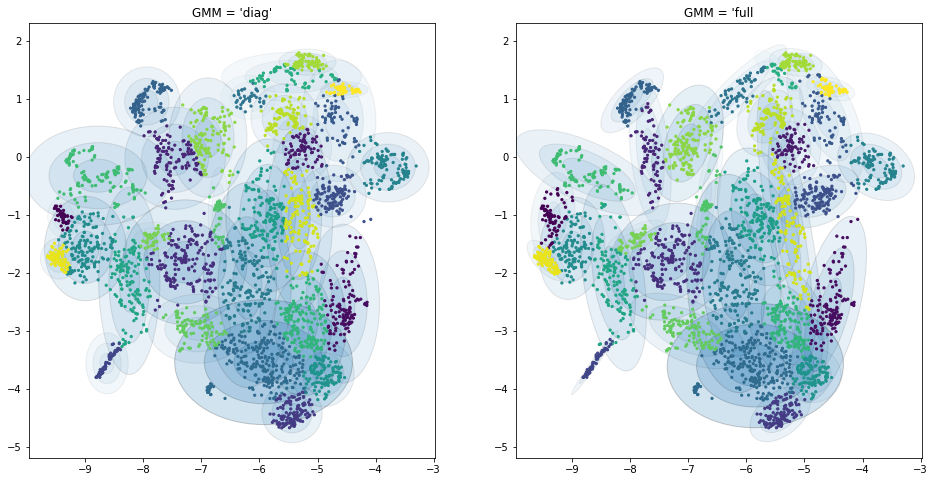

time: 1.75 s


In [61]:
gmm1 = GaussianMixture(n_components=30, random_state=0, covariance_type='diag').fit(vectors_hotel_2d)
gmm2 = GaussianMixture(n_components=30, random_state=0, covariance_type='full').fit(vectors_hotel_2d)

plt.figure(figsize=(16,8))

plt.subplot(121)
plot_gmm(gmm1, vectors_hotel_2d)
plt.title("GMM = 'diag'")

plt.subplot(122)
plot_gmm(gmm2, vectors_hotel_2d)
plt.title("GMM = 'full")

plt.show()

## Difference between topics on GMM 2D vs GMM all

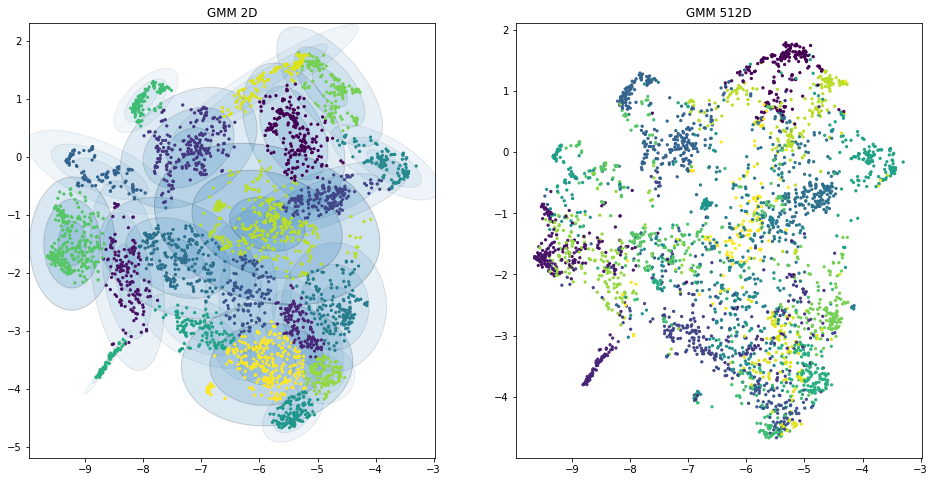

time: 5.63 s


In [62]:
gmm_2d = GaussianMixture(n_components=20, random_state=1, covariance_type='full').fit(vectors_hotel_2d)
gmm_all = GaussianMixture(n_components=20, random_state=1, covariance_type='full').fit(vectors_hotel)

plt.figure(figsize=(16,8))

plt.subplot(121)
plot_gmm(gmm_2d, vectors_hotel_2d)
plt.title("GMM 2D")

plt.subplot(122)
plt.scatter(df_hotel.x, df_hotel.y, s=5, c=gmm_all.predict(vectors_hotel))
plt.title("GMM 512D")

plt.show()

## Topic desciprions

In [63]:
# Load Google model from Tensorflow Hub
import tensorflow_hub as hub
import tensorflow as tf
guse = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()

/anaconda/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



time: 3.06 s


In [99]:
# Find the topic vectors

num_topics = 20
topic_docs = []
for i in range(num_topics):
    df_topic = df_hotel[df_hotel.gmm_topic == i]
    paragraph = '. '.join(df_topic.text.tolist())
    topic_docs.append(paragraph)

# Now each element in topic_docs contains a concatenated topic, for which we will produce a single vector

time: 35 ms


In [65]:
vectors_hotel.shape

(3369, 512)

time: 4.79 ms


In [64]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(num_topics):
    df_topic = df[df.topic==i]
    
    # Make a topic vector
    topic_text = '. '.join(df_topic.text.tolist())
    topic_vector = guse_vectors(topic_text)
    
    # Retreive all the individual vectors for that topic
    individual_vectors = vectors[df.topic==i,:]
    
    # Find closest
    cs = cosine_similarity(topic_vector.reshape(1, -1), individual_vectors)[0]
    idx = np.argmax(cs)
    
    # Display
    print(i, df_topic.iloc[idx].text)

'a. b. c'

time: 88.4 ms


In [101]:
# Function which will take a list of strings (sentences) and return the GUSE vectors
def guse_vectors(x):
  embeddings = guse(x)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(embeddings)

# Generate GUSE vectors
vectors_guse = guse_vectors(topic_docs)

time: 8.37 s


In [145]:
from sklearn.metrics.pairwise import cosine_similarity

# Closest to doc vector
for i in range(num_topics):
    idx = (df_hotel.gmm_topic_more == i)
    df_topic = df_hotel[idx]
    vector_topic = vectors_guse[i]
    vector_topics = vectors_hotel[idx,:]
    cs = cosine_similarity(vector_topic.reshape(1, -1), vector_topics)[0]
    closest_feedback = df_topic.iloc[np.argmax(cs)].text
    print('topic {}'.format(i), closest_feedback[0:100])

topic 0 If you're a family vacation traveller, you'll probably make use of the grocery store often becuse fo
topic 1 my only real complaint would be that the bathroom does not have a separate vanity area, so 2 people 
topic 2 The room was wonderful with great beds, a nice bathroom and we also had an excellent view of Coit To
topic 3 Stay here ,  you won't regret it,  great price ,  great location .
topic 4 great rooms fantastic location and great service !
topic 5 The free wine tasting every night was a wonderful extra and welcomed relaxment in between a long day
topic 6 Don't use the restaurant or room service, there's plenty of places to eat outside the hotel, there's
topic 7 Lovely hotel, terrific location, wonderful helpful staff, immaculately clean rooms .
topic 8 The bathroom was very clean and well appointed with nice towels and toiletries, it was not big, but 
topic 9 We ate in the bistro downstairs and the food was very good ,  although the portions varied significa
topic 10 A

In [146]:
# Closest to median
for i in range(num_topics):
    idx = (df_hotel.gmm_topic == i)
    df_topic = df_hotel[idx]
    vector_topic = np.median(vectors_hotel[idx,:], axis=0)
    vector_topics = vectors_hotel[idx,:]
    cs = cosine_similarity(vector_topic.reshape(1, -1), vector_topics)[0]
    closest_feedback = df_topic.iloc[np.argmax(cs)].text
    print('topic {}'.format(i), closest_feedback[0:100])

topic 0 $52 a night to park, read very carefully about the room service charges,swimming pool and internet c
topic 1 This time, no connecting rooms were available so we booked a one, bedroom, 1 .
topic 2 Hotel was Very nicely furnished, staff was Very helpful .
topic 3 Great Place Even better location
topic 4 great rooms fantastic location and great service !
topic 5 The free morning coffee and evening wine reception were both good opportunities to meet other guests
topic 6 The tube station is right there and the location is great for getting around London .
topic 7 Great Hotel in a Great Location
topic 8 Room and bathroom was very clean .
topic 9 I had breakfast and dinner a few times at the restaurant joined to the hotel, Cafe Pescatore, and th
topic 10 We asked at front desk and then said they would send someone up in 10 minutes, over 1 hour later no 
topic 11 However, parking is $30 night and valet only, which becomes a pain .
topic 12 The rooms are very clean, comfortable and spac

In [143]:
# Revelance method
# https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
from sklearn.feature_extraction.text import CountVectorizer

# BoW for doc
count_vect_doc = CountVectorizer(ngram_range=(1,1))
doc_tokens = df_hotel.tokens.tolist()
doc_bow = count_vect_doc.fit_transform([' '.join(t) for t in doc_tokens])
doc_bow_dense = doc_bow.todense()
doc_vocab = count_vect_doc.get_feature_names()
doc_total_words = doc_bow_dense.sum()

# BoW for topics
count_vect_topic = CountVectorizer(ngram_range=(1,1))
for i in range(num_topics):
    idx = (df_hotel.gmm_topic == i)
    df_topic = df_hotel[idx]
    
    # BoW for topics
    topic_tokens = df_topic.tokens
    topic_bow = count_vect_topic.fit_transform([' '.join(t) for t in topic_tokens])
    topic_vocab = count_vect_topic.get_feature_names()
    topic_bow_dense = topic_bow.todense()

    # Filter doc list to the same topic list
    idx_topic_words = np.array([doc_vocab.index(w) for w in topic_vocab])
    filtered_doc_bow = doc_bow_dense[:,idx_topic_words]

    # Doc counts/probs
    doc_word_counts = np.array(np.sum(filtered_doc_bow, axis=0))[0]
    prob_word_doc = doc_word_counts / doc_total_words

    # Topic counts/probs
    topic_word_counts = np.array(np.sum(topic_bow_dense, axis=0))[0]
    topic_total_words = topic_bow_dense.sum()
    phi_kw = topic_word_counts / topic_total_words

    # Relevance calc
    LAMBDA = 0.6
    relevance = (LAMBDA * np.log(phi_kw)) + ((1-LAMBDA)*np.log(phi_kw/prob_word_doc))

    # Relevance rank
    rel_order = np.argsort(relevance)[::-1]
    top_words = ', '.join([topic_vocab[i] for i in rel_order[0:5]])
    print(i, top_words)

0 in, for, service, internet, of
1 room, pron, have, of, floor
2 staff, room, very, hotel, helpful
3 location, good, great, beat, not
4 great, location, service, excellent, room
5 wine, free, coffee, pm, morning
6 tube, gloucester, station, road, location
7 hotel, location, great, this, good
8 bathroom, clean, room, shower, door
9 food, breakfast, eat, service, restaurant
10 pron, room, not, that, in
11 parking, valet, fee, car, park
12 room, clean, but, small, very
13 wharf, fisherman, location, block, pier
14 hotel, this, location, in, for
15 clean, room, comfortable, bed, very
16 food, restaurant, great, good, breakfast
17 staff, helpful, friendly, very, polite
18 staff, service, customer, desk, front
19 small, room, size, but, in
time: 1.25 s


In [163]:
# Revelance method
# https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
from sklearn.feature_extraction.text import CountVectorizer

# BoW for doc
count_vect_doc = CountVectorizer(ngram_range=(2,2))
doc_tokens = df_hotel.tokens.tolist()
doc_bow = count_vect_doc.fit_transform([' '.join(t) for t in doc_tokens])
doc_bow_dense = doc_bow.todense()
doc_vocab = count_vect_doc.get_feature_names()
doc_total_words = doc_bow_dense.sum()

# BoW for topics
count_vect_topic = CountVectorizer(ngram_range=(2,2))
for i in range(num_topics):
    idx = (df_hotel.gmm_topic == i)
    df_topic = df_hotel[idx]
    
    # BoW for topics
    topic_tokens = df_topic.tokens
    topic_bow = count_vect_topic.fit_transform([' '.join(t) for t in topic_tokens])
    topic_vocab = count_vect_topic.get_feature_names()
    topic_bow_dense = topic_bow.todense()

    # Filter doc list to the same topic list
    idx_topic_words = np.array([doc_vocab.index(w) for w in topic_vocab])
    filtered_doc_bow = doc_bow_dense[:,idx_topic_words]

    # Doc counts/probs
    doc_word_counts = np.array(np.sum(filtered_doc_bow, axis=0))[0]
    prob_word_doc = doc_word_counts / doc_total_words

    # Topic counts/probs
    topic_word_counts = np.array(np.sum(topic_bow_dense, axis=0))[0]
    topic_total_words = topic_bow_dense.sum()
    phi_kw = topic_word_counts / topic_total_words

    # Relevance calc
    LAMBDA = 0.6
    relevance = (LAMBDA * np.log(phi_kw)) + ((1-LAMBDA)*np.log(phi_kw/prob_word_doc))

    # Relevance rank
    rel_order = np.argsort(relevance)[::-1]
    top_words = ', '.join([topic_vocab[i] for i in rel_order[0:5]])
    print(i, top_words)

0 in room, free internet, internet service, across street, internet access
1 pron room, room on, executive room, an executive, room available
2 hotel staff, staff very, staff extremely, clean room, room clean
3 not beat, great location, location but, beat location, can not
4 great location, great room, location service, location friendly, service great
5 free wine, free coffee, wine reception, in morning, wine in
6 gloucester road, road tube, tube station, from gloucester, walk from
7 hotel in, this hotel, great hotel, great location, excellent hotel
8 room clean, very clean, slide door, pron room, in bathroom
9 food service, room service, breakfast include, include in, eat at
10 check in, pron room, not ready, do not, room service
11 valet parking, for parking, parking but, parking expensive, parking fee
12 small but, very clean, room very, room lovely, clean charmingly
13 fisherman wharf, pier 39, cable car, block from, fishermans wharf
14 this hotel, in london, hotel in, tuscan inn,

In [149]:
df_hotel[df_hotel.gmm_topic == 0].text.tolist()

['They provide you with great aveda products in the bathroom .',
 'If your dog tends to be a little disruptive or on the noisy side, there is a bathroom fan that you can keep on to make noise .',
 'large clean bathrooms fully stocked with everything needed .',
 'Bathrooms were also very nice .',
 'The only minor downside, as a few others have mentioned, is the bathroom sink lighting .',
 'There were Italian, Indian, British, American fast food, and Thai restaurants very close to the hotel on Cromwell   Gloucester Rds .',
 'You could buy food from Sainsburys or Waitrose which were 2 minutes away to save money .',
 'Food Drink a little pricey in local establishments .',
 '95 if you want hot food as well .',
 'Not exactly what most tourists are looking for but when you have been out of the states as long as we have you eat fast food when you get the chance !',
 "There is no mini, fridge in standard rooms, so you can't store any food ,  the hotel used to have mini, fridges .",
 'There is a

time: 7.11 ms


In [151]:
df_hotel['internet'] = df_hotel.text.str.lower().str.contains('internet')

time: 343 ms


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [165]:
idx = df_hotel.text.str.lower().str.contains('internet')
df_hotel[idx].groupby('gmm_topic').topic.count()

gmm_topic_more
0     29
1      5
2      3
3      1
4      3
5      2
6      5
10     1
11     1
13     1
14     4
18     3
Name: topic, dtype: int64

time: 11.4 ms


In [160]:
len(df_hotel[df_hotel.gmm_topic==0])

282

time: 4.55 ms
